
<a id='generic-programming'></a>
<a href="#"><img src="/_static/img/jupyter-notebook-download-blue.svg" id="notebook_download_badge"></a>

<script>
var path = window.location.pathname;
var pageName = path.split("/").pop().split(".")[0];
var downloadLink = ["/", "_downloads/ipynb/jl/", pageName, ".ipynb"].join("");
document.getElementById('notebook_download_badge').parentElement.setAttribute('href', downloadLink);
</script>

<a href="/status.html"><img src="https://img.shields.io/badge/Execution%20test-not%20available-lightgrey.svg" id="executability_status_badge"></a>

<div class="how-to">
        <a href="#" class="toggle"><span class="icon icon-angle-double-down"></span>How to read this lecture...</a>
        <div class="how-to-content">
                <p>Code should execute sequentially if run in a Jupyter notebook</p>
                <ul>
                        <li>See the <a href="/jl/getting_started.html">set up page</a> to install Jupyter, Julia (1.0+) and all necessary libraries</li>
                        <li>Please direct feedback to <a href="mailto:contact@quantecon.org">contact@quantecon.org</a> or the <a href="http://discourse.quantecon.org/">discourse forum</a></li>
                        <li>For some notebooks, enable content with "Trust" on the command tab of Jupyter lab</li>
                        <li>If using QuantEcon lectures for the first time on a computer, execute <tt>] add InstantiateFromURL</tt> inside of a notebook or the REPL</li>
                </ul>
        </div>
</div>

# Generic Programming

## Contents

- [Generic Programming](#Generic-Programming)  
  - [Overview](#Overview)  
  - [Exploring Type Trees](#Exploring-Type-Trees)  
  - [Distributions](#Distributions)  
  - [Number, Real, and Algebraic Structures](#Number,-Real,-and-Algebraic-Structures)  
  - [Functions, and Function-Like Types](#Functions,-and-Function-Like-Types)  
  - [Limitations of Dispatching on Abstract Types](#Limitations-of-Dispatching-on-Abstract-Types)  
  - [Understanding Multiple Dispatch in Julia](#Understanding-Multiple-Dispatch-in-Julia)  

> I find OOP methodologically wrong. It starts with classes. It is as if mathematicians would start with axioms. You do not start with axioms - you start with proofs. Only when you have found a bunch of related proofs, can you come up with axioms. You end with axioms. The same thing is true in programming: you have to start with interesting algorithms. Only when you understand them well, can you come up with an interface that will let them work. - Alexander Stepanov

## Overview

In this lecture we delve more deeply into the structure of Julia, and in particular into

- abstract and concrete types  
- the type tree  
- designing and using generic interfaces  
- the role of generic interfaces in Julia performance  


Understanding them will help you

- Design code that matches the “white-board” mathematics  
- Create code that can use (and be used) by a variety of other packages  
- Write “well organized” Julia code that’s easy to read, modify, maintain and debug  
- Improve the speed at which your code runs  


(Special thank you to Jeffrey Sarnoff)

### Generic Programming is an Attitude

From `Mathematics to Generic Programming` [[SR14]](zreferences.html#stepanov-mathematics-2014)

> Generic programming is an approach to programming that focuses on designing algorithms and data structures so that they work in the most general setting without loss of efficiency… Generic programming is more of an *attitude* toward programming than a particular set of tools.


In that sense, it is important to think of generic programming not as a set of rules to apply about decomposing taxonomies of abstractions, but rather as an interactive approach in attempting to uncover generality without any performance overhead

As we will see, the core approach is to treat data-structures and algorithms as loosely coupled, and is in direct contrast to the “isa” approach of object-oriented programming

This lecture has the dual role of giving an introduction into the design of generic algorithms, and describing how Julia helps make that possible

### Setup

In [1]:
using InstantiateFromURL

# activate the QuantEcon environment
activate_github("QuantEcon/QuantEconLecturePackages", tag = "v0.9.0") 

using LinearAlgebra, Statistics, Compat # load common packages

┌ Warning: On Windows, creating file symlinks requires Administrator privileges
└ @ Base.Filesystem file.jl:789


## Exploring Type Trees

The connection between data-structures and the algorithms which operate on them is handled the through the type system

Concrete types (i.e. `Float64` or `Array{Float64, 2}`) are the data-structures we have in mind for working with algorithms, and the abstract types we have seen before (e.g. `Number` and `AbstractArray`) provide the mapping a particular set of data structures to a particular algorithm

In [2]:
using Distributions
x = 1
y = Normal()
z = "foo"
@show x, y, z
@show typeof(x), typeof(y), typeof(z)
@show supertype(typeof(x))
@show typeof(x) |> supertype  # pipe operator(|>), just applies a function to another function
@show supertype(typeof(y))
@show typeof(z) |> supertype
@show typeof(x) <: Any;

(x, y, z) = (1, Normal{Float64}(μ=0.0, σ=1.0), "foo")


(typeof(x), typeof(y), typeof(z)) = (Int64, Normal{Float64}, String)
supertype(typeof(x)) = Signed
typeof(x) |> supertype = Signed
supertype(typeof(y)) = Distribution{Univariate,Continuous}
typeof(z) |> supertype = AbstractString
typeof(x) <: Any = true


Beyond the `typeof` and `supertype`, a few other useful tools for analyzing the tree of types were discussed in [this lecture](introduction_to_types)

In [3]:
using Base: show_supertypes # import the function from the `Base` package

show_supertypes(Int64)

Int64 <: Signed <: Integer <: Real <: Number <: Any

In [4]:
subtypes(Integer)

3-element Array{Any,1}:
 Bool    
 Signed  
 Unsigned

Using the `subtypes` function, we can traverse the type tree below a particular type

In [5]:
#  from https://github.com/JuliaLang/julia/issues/24741
function subtypetree(t, level=1, indent=4)
        if level == 1
            println(t)
        end
        for s in subtypes(t)
            println(join(fill(" ", level * indent)) * string(s))  # print type
            subtypetree(s, level+1, indent)  # recursively print the next types, indenting
        end
    end

subtypetree (generic function with 3 methods)

Using this function, we can see all of the current types in memory below `Number` in the tree

In [6]:
subtypetree(Number) # warning: do not use this function on ``Any``!

Number
    Complex
    Real
        AbstractFloat
            BigFloat
            Float16
            Float32
            Float64
        AbstractIrrational
            Irrational
        Integer
            Bool
            Signed
                BigInt
                Int128
                Int16
                Int32
                Int64
                Int8
            Unsigned
                UInt128
                UInt16
                UInt32
                UInt64
                UInt8
        Rational


For the most part, all of the “leaves” will be concrete types

### Any

At the root of all types is `Any`

There are a number of operations which are available for `Any`, including a `show` function and `typeof`

There are a few functions that work in the “most generalized” context: usable with anything that you can construct or access from other packages

We have already called `typeof` and `supertype` on a number of types, and this will work by default for custom types

In [7]:
# custom type
struct MyType
    a::Float64
end

myval = MyType(2.0)
@show myval
@show typeof(myval)
@show supertype(typeof(myval))
@show typeof(myval) <: Any;

myval = MyType(2.0)
typeof(myval) = MyType
supertype(typeof(myval)) = Any
typeof(myval) <: Any = true


Here we see an important example of generic programming: every type `<: Any` supports the `@show` macro, which in turn, relies on the `show` function

What does the `@show` macro do?  It (1) prints the expression as a string; (2) evaluates the expression; and (3) calls the `show` function on the returned types

To see this with built-in types

In [8]:
x = [1, 2]
show(x)

[1, 2]

The `Any` type is useful, because it provides a fall-back implementation for a variety of functions, such as the `show`

In [9]:
myval = MyType(2.0)
show(myval)

MyType(2.0)

The default implementation used by Julia would look something like

```julia
function show(io::IO, x::MyType)
    str = string(x)
    print(io, str)
end
```


To implement a “best practice” and provide a specialized implementation of the `show` function for our type rather than the fllback

In [10]:
import Base.show  # to extend an existing method

function show(io::IO, x::MyType)
    str = "(MyType.a = $(x.a))"
    print(io, str)
end
show(myval)  # it creates an IO value first and then calls the above show

(MyType.a = 2.0)

At that point, the `@show` macro works by calling the `show` function

In [11]:
@show myval;

myval = (MyType.a = 2.0)


### Unlearning Object Oriented (OO) Programming (Advanced)

See [Types](https://docs.julialang.org/en/v1/manual/types/#man-types-1) for more on OO vs. generic types

If you have never used programming languages such as C++, Java, Python, etc., then the type hierarchies above may seem unfamiliar and abstract–but there is no need to read this section

Otherwise, if you have used object-oriented programming (OOP) in those languages, then some of the concepts in these lecture notes will appear familiar

**Don’t be fooled!**

The superficial similarity can lead to misuse: types are *not* just classes with poor encapsulation, and methods are *not* simply the equivalent to member functions with the order of arguments swapped

In particular, previous OO knowledge often leads people to write Julia code such as

In [12]:
# BAD! Replicating an OO design in Julia
mutable struct MyModel
    a::Float64
    b::Float64
    algorithmcalculation::Float64

    MyModel(a, b) = new(a, b, 0.0) # an inner constructor
end

function myalgorithm!(m::MyModel, x)
    m.algorithmcalculation = m.a + m.b + x # some algorithm
end

function set_a!(m::MyModel, a)
    m.a = a
end

m = MyModel(2.0, 3.0)
x = 0.1
set_a!(m, 4.1)
myalgorithm!(m, x)
@show m.algorithmcalculation;

m.algorithmcalculation = 7.199999999999999


You may think to yourself that the above code is similar to OO, except that you
* reverse the first argument, i.e. `myalgorithm!(m, x)` instead of the object-oriented `m.myalgorithm!(x)`
* cannot control encapsulation of the fields `a, b`, but you can add getter/setters like `set_a`
* do not have concrete inheritance

While this sort of programming is possible, it is (verbosely) missing the point of Julia and the power of generic programming

It may be helpful to review the traditional pillars of OOP
* *`Abstraction <https://en.wikipedia.org/wiki/Abstraction_(computer_science)#Abstraction_in_object_oriented_programming>`_:* In OO one develops a taxonomy of hierarchical “is-a” relationships as “classes”, where the key abstraction involves describing interactions between the self-contained “classes”
* *`Encapsulation <https://en.wikipedia.org/wiki/Encapsulation_(computer_programming)>`_:* Most OO code has fully mutable classes, where access to the internals is tightly controlled since the class manages its own state
* *`Inheritance <https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)>`_* Code reuse in OO is achieved through adding a new class to the tree and inheriting some of the behavior of the parent class.
* *`Polymorphism <https://en.wikipedia.org/wiki/Polymorphism_(computer_science)>`_:*  The abstract “is-a” relationships between types in a taxonomy provide a way to have the same function change its behavior given the particular type

When programming in Julia
* There will be no encapsulation or inheritance, most custom types you create will be immutable, and polymorphism will be fundamentally different
* Abstraction is primarily achieved through keeping the data and algorithms that operate on them as orthogonal as possible–in contrast to OOP
* The supertypes in Julia are simply used for selecting which specialized algorithm to use (i.e. part of generic polymorphism) and have nothing to do with OO inheritance
* The looseness that accompanies keeping algorithms and data-structures as orthogonal as possible makes it easier to discover commonality in the design

#### Iterative Design of Abstractions

As its essence, the design of generic software is that you will start with creating algorithms which are largely orthogonal to concrete types, and in the process you will discover commonality which leads to abstract types with informally defined functions operating on them

This design is in direct contrast to object-oriented design and analysis ([OOAD](https://en.wikipedia.org/wiki/Object-oriented_analysis_and_design)), where you specify a taxonomies of types, add operations to those types, and then move down to various levels of specialization (where algorithms are embedded at points within the taxonomy, and potentially specialized with inheritance)

In the examples that follow, we will show for exposition the hierarchy of types and the algorithms operating on them, but the reality is that the algorithms are often designed first, and the abstact types came later
.. However,  we apologize in the example we confuse things somewhat by jumping to the axioms first for expositoin

## Distributions

First, lets consider working with “distributions”

If we consider mathematical “distributions” that we will use in our algorithms, they may include (1) drawing random numbers for Monte-carlo methods; (2) using the pdf or cdf in various calculations

In that sense, some code may be useful in distributions where a `pdf` is not necessarily defined or meaningful

The process of using concrete distributions in these sorts of applications led to the creation of the Distributions.jl package

Lets examine the tree of types for a Normal distribution

In [13]:
using Distributions
d1 = Normal(1.0, 2.0) # an example type to explore
@show d1
show_supertypes(typeof(y))

d1 = Normal{Float64}(μ=1.0, σ=2.0)
Normal{Float64} <: Distribution{Univariate,Continuous} <: Sampleable{Univariate,Continuous} <: Any

The `Sampleable{Univariate,Continuous}` type has a limited number of functions, chiefly the ability to draw a random number

In [14]:
@show rand(d1);

rand(d1) = 0.988779198199741


The purpose of that abstract type is to provide an interface for drawing from a variety of distributions, some of which may not have a well-defined predefined pdfs

If you were writing a function to simulate a stochastic process with an arbitrary iid shocks, where you did not need to assume an existing of a `pdf` etc., this is a natural candidate

For example, to simulate $ x_{t+1} = a x_t + b \epsilon_{t+1} $ where $ \epsilon \sim D $ for some $ D $ which allows drawing random values

In [15]:
function simulateprocess(x₀; a = 1.0, b = 1.0, N = 5, d::Sampleable{Univariate,Continuous})
    x = zeros(typeof(x₀), N+1) # preallocate vector, careful on the type
    x[1] = x₀
    for t in 2:N+1
        x[t] = a * x[t-1] + b * rand(d) # draw
    end
    return x
end
@show simulateprocess(0.0, d=Normal(0.2, 2.0));

simulateprocess(0.0, d=Normal(0.2, 2.0)) = [0.0, 0.588168, 1.43876, 5.0301, 5.85238, 6.85352]


The `Sampleable{Univariate,Continuous}` and, especially, the `Sampleable{Multivariate,Continuous}` abstract types are useful generic interfaces for monte-carlo and Bayesian methods, in particular, where you can often draw from a distribution, but can do little else

Moving down the tree, the `Distributions{Univariate, Continuous}` abstract type has certain functions we would expect to operate with it

These match the mathematics, such as `pdf, cdf, quantile, support, minimum, maximum` and a few others

In [16]:
d1 = Normal(1.0, 2.0)
d2 = Exponential(0.1)
@show d1
@show d2
@show supertype(typeof(d1))
@show supertype(typeof(d2))

@show pdf(d1, 0.1)
@show pdf(d2, 0.1)
@show cdf(d1, 0.1)
@show cdf(d2, 0.1)
@show support(d1)
@show support(d2)
@show minimum(d1)
@show minimum(d2)
@show maximum(d1)
@show maximum(d2);

d1 = Normal{Float64}(μ=1.0, σ=2.0)
d2 = Exponential{Float64}(θ=0.1)
supertype(typeof(d1)) = Distribution{Univariate,Continuous}
supertype(typeof(d2)) = Distribution{Univariate,Continuous}
pdf(d1, 0.1) = 0.18026348123082397
pdf(d2, 0.1) = 3.6787944117144233
cdf(d1, 0.1) = 0.32635522028792
cdf(d2, 0.1) = 0.6321205588285577
support(d1) = RealInterval(-Inf, Inf)
support(d2) = RealInterval(0.0, Inf)
minimum(d1) = -Inf
minimum(d2) = 0.0
maximum(d1) = Inf
maximum(d2) = Inf


You could create your own `Distributions{Univariate, Continuous}` type, if you implemented all of those functions, as is described in [the documentation](https://juliastats.github.io/Distributions.jl/latest/extends.html)

If you fulfill all of the conditions of a particular interface, you (or anyone else) could use code written for the abstract `Distributions{Univariate, Continuous}` type without any modifications

As an example, consider the [StatPlots](https://github.com/JuliaPlots/StatPlots.jl) package

┌ Info: Precompiling StatPlots [60ddc479-9b66-56df-82fc-76a74619b69c]
└ @ Base loading.jl:1192
┌ Info: Recompiling stale cache file C:\Users\jlperla\.julia\compiled\v1.0\KernelDensity\4QyGx.ji for KernelDensity [5ab0869b-81aa-558d-bb23-cbf5423bbe9b]
└ @ Base loading.jl:1190


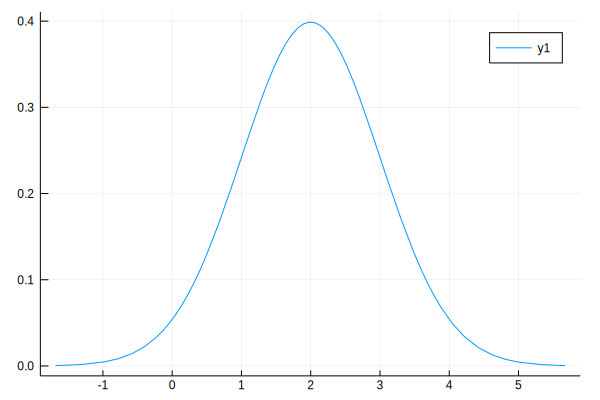

In [17]:
using StatPlots
d = Normal(2.0, 1.0)
plot(d) # note no other arguments!

The `plot` function when applied to anything which is a subtype of `Distributions{Univariate, Continuous}`, will display the `pdf` using the `minimum` and `maximum` applied to the value

To demonstrate this, lets create our own distribution type

In [18]:
struct OurTruncatedExponential <: Distribution{Univariate,Continuous}
    α::Float64
    xmax::Float64
end
Distributions.pdf(d::OurTruncatedExponential, x) = d.α *exp(-d.α * x)/exp(-d.α * d.xmax)
Distributions.minimum(d::OurTruncatedExponential) = 0
Distributions.maximum(d::OurTruncatedExponential) = d.xmax
# ... should implement all of them, but this was enough

To demonstrate this

In [19]:
d = OurTruncatedExponential(1.0,2.0)
@show minimum(d), maximum(d)
@show support(d) # why does this work?

(minimum(d), maximum(d)) = (0, 2.0)
support(d) = RealInterval(0.0, 2.0)


RealInterval(0.0, 2.0)

Curiously, you will note that the `support` function is operational, even though we did not provide one

This is another example of the power of multiple dispatch and generic programming

In the background, the `Distributions.jl` package  has something like the following implemented

```julia
    Distributions.support(d::Distribution) = RealInterval(minimum(d), maximum(d))
```


Hence, since `OurTruncatedExponential <: Distribution`, and we implemented `minimum` and `maximum`, calls to `support` gets this implementation

Of course, while we should implement more of the func

That turns out to be enough for us to use the `StatPlots` package

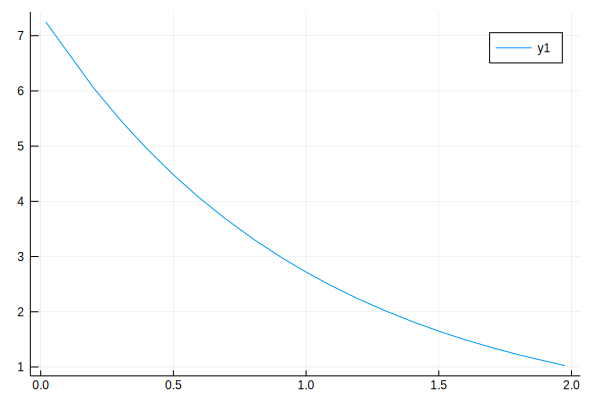

In [20]:
plot(d) # uses the generic code!

A few things to point out

- Even if it worked for `StatPlots`, our implementation is incomplete, as we haven’t fulfilled all of the requirements of a `Distribution`  
- We also did not implement the `rand` function, which means we are breaking the implicit contract of the `Sampleable` abstract type  
- It turns out that there is a better way to to this precise thing already built into `Distributions`  

typeof(d) = Truncated{Exponential{Float64},Continuous}


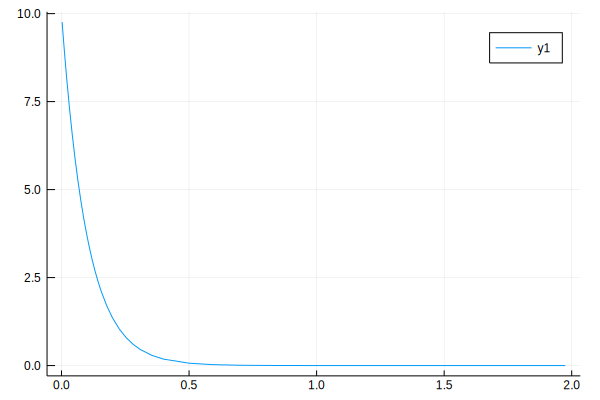

In [21]:
d = Truncated(Exponential(0.1), 0.0, 2.0)
@show typeof(d)
plot(d)

This is the power of generic programming in general, and Julia in particular: you can combine and compose completely separate packages and code, as long as there is an agreement on abstract types and functions

## Number, Real, and Algebraic Structures

In mathematics, a [Ring](https://en.wikipedia.org/wiki/Ring_(mathematics)) is a set with two binary operators ($ + $ and $ \cdot $, called the additive and multiplicative operators) where there is an
* additive operator is associative and commutative
* multiplicative operator is associative and and distributive with respect to the additive operator
* additive identity element, usually denoted `0` such that $ a + 0 = a $ for any $ a $ in the set
* additive inverse of each element, i.e. $ -a $ such that $ a + (-a) = 0 $
* multiplicative identity element, usually denoted `1` such that $ a \cdot 1 = a $

This is skipping over a few other key parts of the definition, but it is also useful to say what is not needed
* A total or partial ordering is not required (i.e. there does not need to be any meaningful `<` operator defined)
* A multiplicative inverse is not required

This algebraic structure provides motivation for the abstract `Number` type in Julia

**Remark** We use motivation here because they are not formally connected and the mapping is imperfect

- The main difficulty when dealing with numbers that can be concretely created on a computer is that the closure requirements are difficult to ensure (e.g. floating points have finite numbers of bits of information)  


Let `typeof(a) = typeof(b) = T <: Number`, then under an implicit definition of the **generic interface** for `Number` the following must be defined
* the additive operator: `a + b`
* the multiplicative operator: `a * b`
* an additive inverse operator: `-a`
* an inverse operation for addition `a - b = a + (-b)`
* an additive identity: `zero(T)` or `zero(a)` for convenience
* a multiplicative identity: `one(T)` or `one(a)` for convenience

The core of generic programming is that, given the knowledge that a value is of type `Number`, we can write to that generic interface

To demonstrate these for a complex number or a big integer (i.e., two types other than the standard `Float64` `Int64` you may associate with numbers)

In [22]:
a = 1.0 + 1.0im
b = 0.0 + 2.0im
@show typeof(a)
@show typeof(a) <: Number
@show a + b
@show a * b
@show -a
@show a - b
@show zero(a)
@show one(a);

typeof(a) = Complex{Float64}
typeof(a) <: Number = true
a + b = 1.0 + 3.0im
a * b = -2.0 + 2.0im
-a = -1.0 - 1.0im
a - b = 1.0 - 1.0im
zero(a) = 0.0 + 0.0im
one(a) = 1.0 + 0.0im


In [23]:
a = BigInt(10)
b = BigInt(4)
@show typeof(a)
@show typeof(a) <: Number
@show a + b
@show a * b
@show -a
@show a - b
@show zero(a)
@show one(a);

typeof(a) = BigInt
typeof(a) <: Number = true
a + b = 14
a * b = 40
-a = -10
a - b = 6
zero(a) = 0
one(a) = 1


Thinking back to the mathematical motivation, a [Field](https://en.wikipedia.org/wiki/Field_(mathematics)) is an Ring with a few additional properties, among them
* a multiplicative inverse: $ a^{-1} $
* an inverse operation for multiplication: $ a / b = a \cdot b^{-1} $
* a (not strictly required) total ordering operation: $ a < b $

where the  [total ordering](https://en.wikipedia.org/wiki/Total_order#Strict_total_order)  operation would fulfill the requirements for a Totally Ordered Field

This type gives some motivation for the operations and properties of the `Real` type

Of course, `Complex{Float64} <: Number` but not `Real`, which makes sense since those operations are not defined for the basic Complex number type in mathematics

These operations are implemented in any subtype of `Real` through
* the multiplicative inverse: `inv(a)`
* the multiplicative inverse operation: `a / b = a * inv(b)`
* an ordering `a < b`

To demonstrate with the `Rational` type

In [24]:
a = 1 // 10
b = 4 // 6
@show typeof(a)
@show typeof(a) <: Number
@show typeof(a) <: Real
@show inv(a)
@show a / b
@show a < b;

typeof(a) = Rational{Int64}
typeof(a) <: Number = true
typeof(a) <: Real = true
inv(a) = 10//1
a / b = 3//20
a < b = true


**Remark** Here we see where and how the precise connection to the mathematics for number types breaks down for practical reasons, in particular
* `Integer` types (i.e. `Int64 <: Integer`) do not have a a multiplicative inverse with closure in the set
* However, it is necessary in practice for integer division to be defined, and return back a member of the `Reals`
* This is called [type promotion](https://docs.julialang.org/en/v1/manual/conversion-and-promotion/#Promotion-1), where a type can be converted to another to ensure an operation is possible by direct conversion between types (i.e. it can be independent of the type hierarchy)

Do not think of the break in the connection between the underlying algebraic structures and the code as a failure of the language or design, but rather that the underlying algorithms for use on a computer do not perfectly fit the algebraic structures in this instance

Moving further down the tree of types provides more operations, which start to become more tied to the computational implementation than the mathematics

For example, floating point numbers all have a machine precision below which there is no way to further differentiate numbers

In [25]:
@show Float64 <: AbstractFloat
@show BigFloat <: AbstractFloat
@show eps(Float64)
@show eps(BigFloat);

Float64 <: AbstractFloat = true
BigFloat <: AbstractFloat = true
eps(Float64) = 2.220446049250313e-16
eps(BigFloat) = 1.727233711018888925077270372560079914223200072887256277004740694033718360632485e-77


The `isless` function also has multiple methods

First let’s try with integers

In [26]:
@which isless(1, 2)

isless(x::Real, y::Real) in Base at operators.jl:338

As we saw previously, the Real data type is an *abstract* type, and encompasses both floats and integers

If we go to the provided link in the source, we see the entirety of the function is

```julia
isless(x::Real, y::Real) = x<y
```


That is, for any values where `typeof(x) <: Real` and `typeof(y) <: Real`, the definition relies on `<`

We know that `<` is defined for the types because it is part of the informal interface for the `Real` abstract type

Note that this is not defined for `Number` because not all `Number` types have the `<` operator defined (e.g. `Complex`)

Of course, in order to generate fast code,

In [27]:
isless(1.0, 2.0)  # Applied to two floats

true

In [28]:
@which isless(1.0, 2.0)

isless(x::Float64, y::Float64) in Base at float.jl:459

Note that the reason  `Float64 <: Real`

## Functions, and Function-Like Types

Another common example of the separation between data structures and algorithms is the use of functions

Syntactically, we should consider a univariate “function” any `f` that can call an argument `x` as `f(x)` for a general `x`

For example, we can use a standard function

integrate(f, 0.0, 1.0) = (0.3333333333333333, 5.551115123125783e-17)


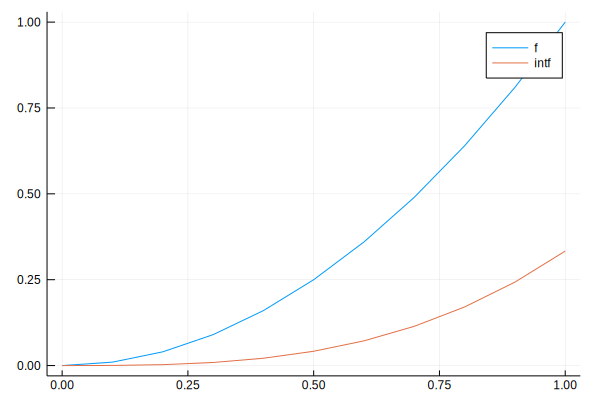

In [29]:
using QuadGK
const integrate = quadgk  # example of setting an alias
f(x) = x^2
@show integrate(f, 0.0, 1.0)  # integral

function plotfunctions(f)
    intf(x) = integrate(f, 0.0, x)[1]  # int_0^x f(x) dx

    x = 0:0.1:1.0
    f_x = f.(x)
    plot(x, f_x, label="f")
    plot!(x, intf.(x), label="intf")
end
plotfunctions(f)  # call with our f

Of course, polynomials are also functions in every important sense

p = Poly(2 - 5*x + 2*x^2)
p(1.0) = -1.0


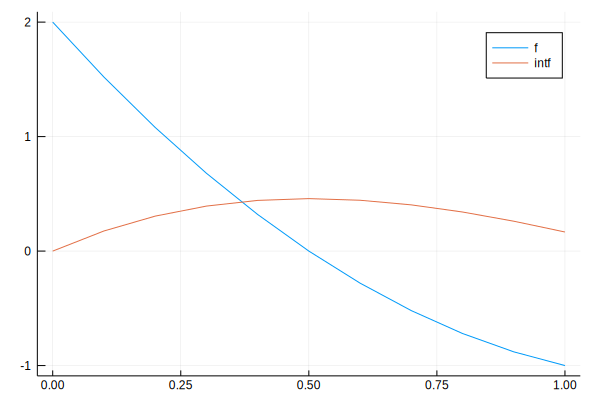

In [30]:
using Polynomials
p = Poly([2, -5, 2], :x)  # :x just gives a symbol for display
@show p
@show p(1.0) # call like a function

plotfunctions(p)  # same generic function

Or Interpolations

f_int(1.0) = 1.0


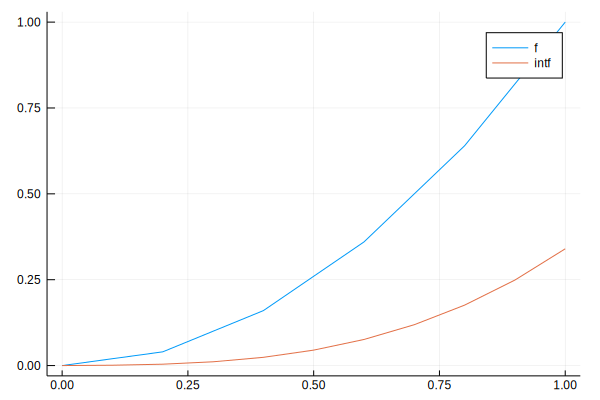

In [31]:
using Interpolations
x = 0.0:0.2:1.0
f(x) = x^2
f_int = LinearInterpolation(x, f.(x))  # interpolating those points
@show f_int(1.0)  # call like a function

plotfunctions(f_int)  # same generic function

Note that the same generic `plotfunctions` could use any variable passed to it that “looks” like a function, i.e. can call `f(x)`

This sort of typing and design–generic but without any declarations–is usually called [duck typing](https://en.wikipedia.org/wiki/Duck_typing)

If you need to make an existing type callable, see [Function Like Objects](https://docs.julialang.org/en/v1/manual/methods/#Function-like-objects-1)

## Limitations of Dispatching on Abstract Types

You will notice that types in Julia represent a tree with `Any` at the root

The tree structure has worked well for the above examples, but it doesn’t allow us to associate multiple categorizations of types

For example, a semi-group type would be very useful for a writing generic code (e.g. continuous-time solutions for ODEs and matrix-free methods) but cannot be implemented rigorously since the `Matrix` type is a semi-group, but it is also an `AbstractArray`

The main way to implement this in a generic language is with a feature called traits

See the [original discussion](https://github.com/JuliaLang/julia/issues/2345#issuecomment-54537633) and an [example of a package to facilitate the pattern](https://github.com/mauro3/SimpleTraits.jl)

A complete description of the Traits patterns as the natural evolution of Multiple Dispatch is given in this [blog post](https://white.ucc.asn.au/2018/10/03/Dispatch,-Traits-and-Metaprogramming-Over-Reflection.html)

## Understanding Multiple Dispatch in Julia

This section provides more background on how methods, functions, and types are connected

### Methods and Functions

The precise data type is important, for reasons of both efficiency and mathematical correctness

For example consider 1 + 1 vs. 1.0 + 1.0 or [1 0] + [0 1]

On a CPU, integer and floating point addition are different things, using a different set of instructions

Julia handles this problem by storing multiple, specialized versions of functions like addition, one for each data type or set of data types

These individual specialized versions are called **methods**

When an operation like addition is requested, the Julia compiler inspects the type of data to be acted on and hands it out to the appropriate method

This process is called **multiple dispatch**

Like all “infix” operators, 1 + 1 has the alternative syntax +(1, 1)

In [32]:
+(1, 1)

2

This operator + is itself a function with multiple methods

We can investigate them using the @which macro, which shows the method to which a given call is dispatched

In [33]:
x, y = 1.0, 1.0
@which +(x, y)

+(x::Float64, y::Float64) in Base at float.jl:395

We see that the operation is sent to the `+` method that specializes in adding
floating point numbers

Here’s the integer case

In [34]:
x, y = 1, 1
@which +(x, y)

+(x::T, y::T) where T<:Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8} in Base at int.jl:53

This output says that the call has been dispatched to the + method
responsible for handling integer values

(We’ll learn more about the details of this syntax below)

Here’s another example, with complex numbers

In [35]:
x, y = 1.0 + 1.0im, 1.0 + 1.0im
@which +(x, y)

+(z::Complex, w::Complex) in Base at complex.jl:266

Again, the call has been dispatched to a + method specifically designed for handling the given data type

#### Adding Methods

It’s straightforward to add methods to existing functions

For example, we can’t at present add an integer and a string in Julia (i.e. `100 + "100"` is not valid syntax)

This is sensible behavior, but if you want to change it there’s nothing to stop you:

In [36]:
import Base: +  # enables extension of the + function

+(x::Integer, y::String) = x + parse(Int, y)

@show +(100, "100")
@show 100 + "100";  # equivalent

100 + "100" = 200
100 + "100" = 200


### Understanding the Compilation Process

We can now be a little bit clearer about what happens when you call a function on given types

Suppose we execute the function call `f(a, b)` where `a` and `b`
are of concrete types `S` and `T` respectively

The Julia interpreter first queries the types of `a` and `b` to obtain the tuple `(S, T)`

It then parses the list of methods belonging to `f`, searching for a match

If it finds a method matching `(S, T)` it calls that method

If not, it looks to see whether the pair `(S, T)` matches any method defined for *immediate parent types*

For example, if `S` is `Float64` and `T` is `ComplexF32` then the
immediate parents are `AbstractFloat` and `Number` respectively

In [37]:
supertype(Float64)

AbstractFloat

In [38]:
supertype(ComplexF32)

Number

Hence the interpreter looks next for a method of the form `f(x::AbstractFloat, y::Number)`

If the interpreter can’t find a match in immediate parents (supertypes) it proceeds up the tree, looking at the parents of the last type it checked at each iteration

- If it eventually finds a matching method it invokes that method  
- If not, we get an error  


This is the process that leads to the following error

In [39]:
+(100, "100")

200

Because the dispatch procedure starts from concrete types and works upwards, dispatch always invokes the *most specific method* available

For example, if you have methods for function `f` that handle

1. `(Float64, Int64)` pairs  
1. `(Number, Number)` pairs  


and you call `f` with `f(0.5, 1)` then the first method will be invoked

This makes sense because (hopefully) the first method is optimized for
exactly this kind of data

The second method is probably more of a “catch all” method that handles other
data in a less optimal way

Here’s another simple example, involving a user-defined function

In [40]:
function genericf(x)  # or f(x::Any)
    println("Default (Any) method invoked")
end

function genericf(x::Number)
    println("Number method invoked")
end

function genericf(x::Integer)
    println("Integer method invoked")
end

genericf (generic function with 3 methods)

Let’s now run this and see how it relates to our discussion of method dispatch
above

In [41]:
genericf(3)

Integer method invoked


In [42]:
genericf(3.0)

Number method invoked


In [43]:
genericf("foo")

Default (Any) method invoked


Since `typeof(3) <: Int64 <: Integer <: Number`, the call `f(3)` proceeds up the tree to `Integer` and invokes `f(x::Integer)`

On the other hand, `3.0` is a `Float64`, which is not a subtype of  `Integer`

Hence the call `f(3.0)` continues up to `f(x::Number)`

Finally, `f("foo")` is handled by the most function operating on `Any`, since `String` is not a subtype of `Number` or `Integer`

### Analyzing Function Return Types

For the most part, time spent “optimizing” julia code to run faster is able ensuring the compiler can correctly deduce types for all functions

We will discuss this in more detail in [this lecture](need_for_speed.html#), but the macro `@code_warntype` gives us a hint

In [44]:
x = [1, 2, 3]
f(x) = 2x
@code_warntype f(x)

Body::Array{Int64,1}
│╻ *2 1 ─ %1 = invoke Base.broadcast(Base.:*::typeof(*), 2::Int64, _2::Array{Int64,1})::Array{Int64,1}
│   └──      return %1


The `@code_warntype` macro compiles the `f(x)` using the type of `x` as an example–i.e., the `[1, 2, 3]` is used as a prototype for analyzing the compilation, rather than simply calculating the value

Here, the `Body::Array{Int64,1}` tells us the type of the return value of the function when called with types like `[1, 2, 3]` is always a vector of integers

In contrast, consider a function potentially returning `nothing`, as in [this lecture](fundamental_types.html#)

In [45]:
f(x) = x > 0.0 ? x : nothing
@code_warntype f(1)

Body::Union{Nothing, Int64}
│╻╷╷ >1 1 ─ %1 = (Base.sitofp)(Float64, x)::Float64
││╻   <  │   %2 = (Base.lt_float)(0.0, %1)::Bool
│││╻   ==  │   %3 = (Base.eq_float)(0.0, %1)::Bool
│││╻   <  │   %4 = (Base.lt_float)(%1, 9.223372036854776e18)::Bool
│││╻   &  │   %5 = (Base.and_int)(%3, %4)::Bool
│││╻   unsafe_trunc  │   %6 = (Base.fptosi)(Int64, %1)::Int64
│││╻   <  │   %7 = (Base.slt_int)(%6, x)::Bool
│││╻   &  │   %8 = (Base.and_int)(%5, %7)::Bool
│││╻   |  │   %9 = (Base.or_int)(%2, %8)::Bool
│     └──      goto #3 if not %9
│     2 ─      return x
│     3 ─      return Main.nothing


This states that the compiler determines the return type when called with an integer (like `1`) could be one of two different types, `Body::Union{Nothing, Int64}`

A final example is a variation on the above, which returns the maximum of `x` and `0`

In [46]:
f(x) = x > 0.0 ? x : 0.0
@code_warntype f(1)

Body::Union{Float64, Int64}
│╻╷╷ >1 1 ─ %1 = (Base.sitofp)(Float64, x)::Float64
││╻   <  │   %2 = (Base.lt_float)(0.0, %1)::Bool
│││╻   ==  │   %3 = (Base.eq_float)(0.0, %1)::Bool
│││╻   <  │   %4 = (Base.lt_float)(%1, 9.223372036854776e18)::Bool
│││╻   &  │   %5 = (Base.and_int)(%3, %4)::Bool
│││╻   unsafe_trunc  │   %6 = (Base.fptosi)(Int64, %1)::Int64
│││╻   <  │   %7 = (Base.slt_int)(%6, x)::Bool
│││╻   &  │   %8 = (Base.and_int)(%5, %7)::Bool
│││╻   |  │   %9 = (Base.or_int)(%2, %8)::Bool
│     └──      goto #3 if not %9
│     2 ─      return x
│     3 ─      return 0.0


Which shows that, when called with an integer, the type could be that integer or the floating point `0.0`

On the other hand, if we use change the function to return `0` if x <= 0, it is type-unstable with  floating point

In [47]:
f(x) = x > 0.0 ? x : 0
@code_warntype f(1.0)

Body::Union{Float64, Int64}
│╻╷ >1 1 ─ %1 = (Base.lt_float)(0.0, x)::Bool
│    └──      goto #3 if not %1
│    2 ─      return x
│    3 ─      return 0


The solution is to use the `zero(x)` function which returns the additive identity element of type `x`
n the other hand, if we use change the function to return `0` if x <= 0, it is type-unstable with  floating point

In [48]:
@show zero(2.3)
@show zero(4)
@show zero(2.0 + 3im)

f(x) = x > 0.0 ? x : zero(x)
@code_warntype f(1.0)

zero(2.3) = 0.0
zero(4) = 0
zero(2.0 + 3im) = 0.0 + 0.0im
Body::Float64
│╻╷ >5 1 ─ %1 = (Base.lt_float)(0.0, x)::Bool
│    └──      goto #3 if not %1
│    2 ─      return x
│    3 ─      return 0.0
